## Подгрузка данных и создание эксперимента

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from dotenv import load_dotenv
from os import getenv
load_dotenv()

df = pd.read_csv('data/KaggleV2-May-2016.csv')
display(df.head())
display(df.info())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


None

In [4]:
experiment = Experiment(
    api_key=getenv('COMET_API_KEY'),
    project_name='medical-appointment',
    workspace=getenv('WORKSPACE_NAME')
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gettergit/medical-appointment/4bd0cb7aa9e84ae7bcce110e9684b675



***
## Визуализация признаков и очистка данных

{'web': 'https://www.comet.com/api/image/download?imageId=609a4172076445e888d9cd14379bac37&experimentKey=4bd0cb7aa9e84ae7bcce110e9684b675',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=609a4172076445e888d9cd14379bac37&experimentKey=4bd0cb7aa9e84ae7bcce110e9684b675',
 'imageId': '609a4172076445e888d9cd14379bac37'}

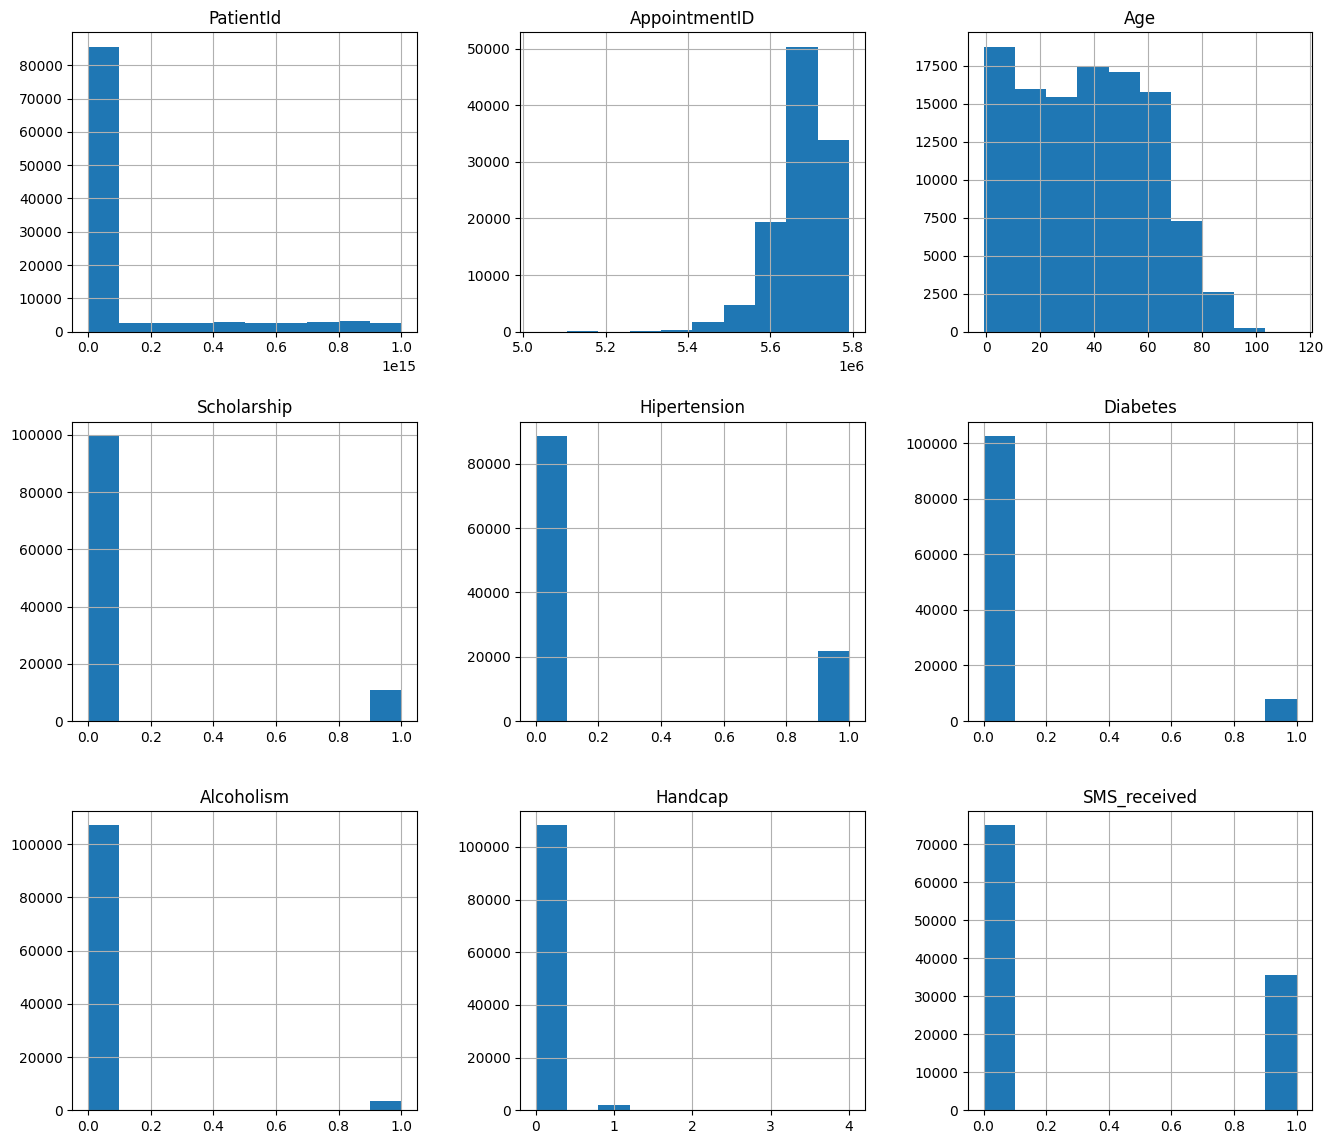

In [5]:
df.hist(figsize=(16,14));
#логируем гистограмму
experiment.log_figure(figure=plt)

In [6]:
# finding unqiue ages
print("Уникальные значения в `Age` => {}".format(df.Age.unique()))

Уникальные значения в `Age` => [ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]


In [7]:
# deleting anomalies
df = df[(df.Age >= 0) & (df.Age <= 110)]
df.Age.value_counts()

Age
0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
97       11
98        6
100       4
102       2
99        1
Name: count, Length: 102, dtype: int64

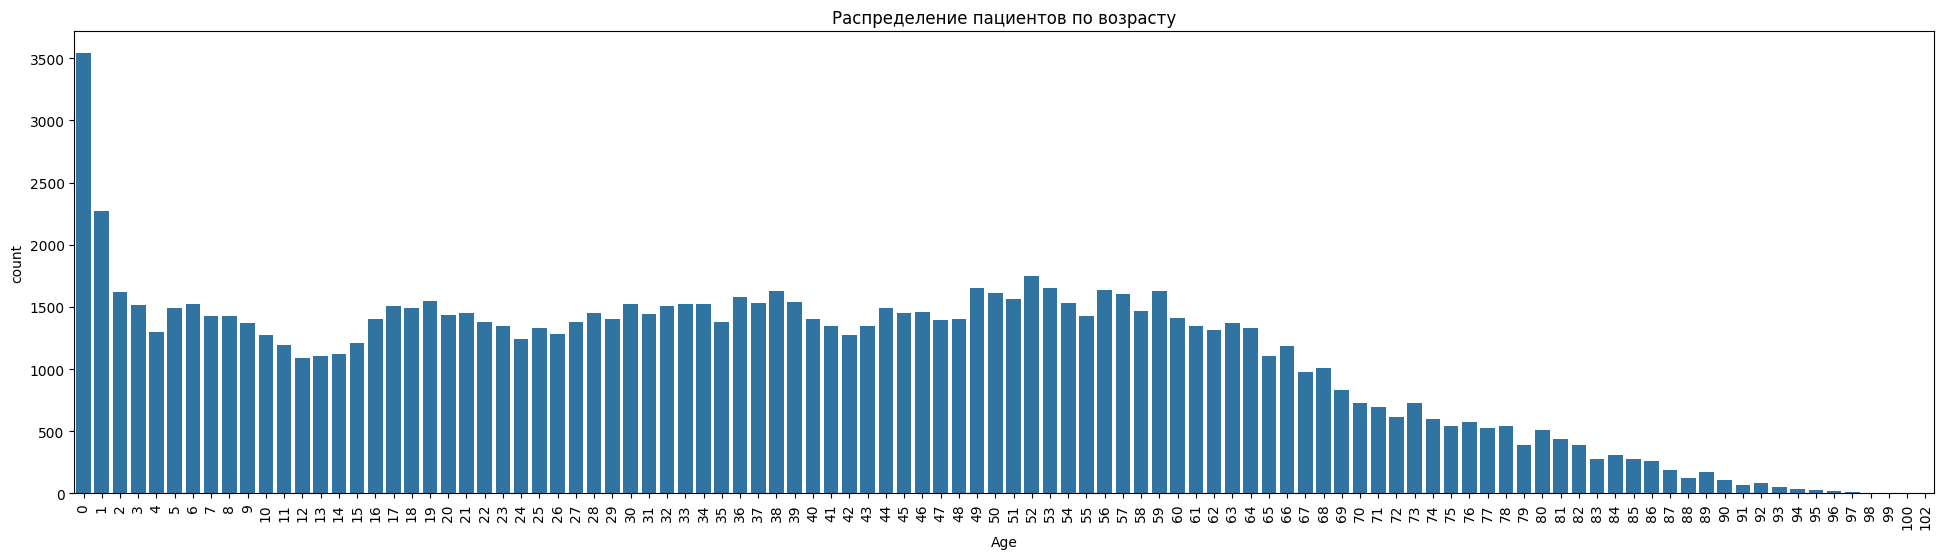

In [8]:
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("Распределение пациентов по возрасту")
experiment.log_figure(figure=plt)
plt.show()

***
## Построение модели

In [9]:
# encoding cat attributes
categorical_columns_names = ['Gender', 'Neighbourhood']
encoded_columns = pd.get_dummies(df, columns = categorical_columns_names)
encoded_columns.drop(['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'No-show'], axis=1, inplace = True)
encoded_columns.head()

# creating the target attribute
y = df['No-show']
y = y.replace({'No': 0, 'Yes': 1})

In [10]:
# data scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(encoded_columns)

In [11]:
# init log regr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
random_state = 42
logreg.fit(X, y)

# logging fitting params
params = {
    "random_state": random_state,
    "model_type": "logreg"
}
experiment.log_parameters(params)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***
## Предсказания модели

In [12]:
y_pred = logreg.predict(X)

# analyzing pred accurancy
accuracy = accuracy_score(y, y_pred)
print("Доля правильных ответов: {:6.3f}".format(accuracy))

# logging metrics
metrics = {"accuracy": accuracy}
experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y.tolist(), y_pred.tolist())

Доля правильных ответов:  0.798


{'web': 'https://www.comet.com/api/asset/download?assetId=fe87b8c9675443e4a7466c56197711ae&experimentKey=4bd0cb7aa9e84ae7bcce110e9684b675',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=fe87b8c9675443e4a7466c56197711ae&experimentKey=4bd0cb7aa9e84ae7bcce110e9684b675',
 'assetId': 'fe87b8c9675443e4a7466c56197711ae'}

***
## Визуализация корреляции между числовыми признаками

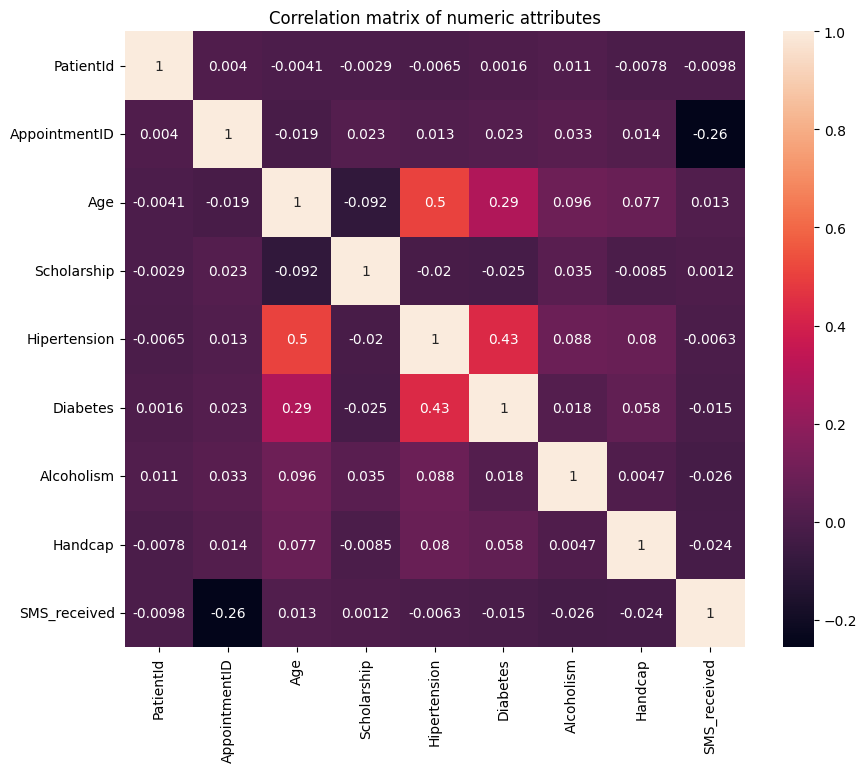

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : very_cucumber_8404
COMET INFO:     url                   : https://www.comet.com/gettergit/medical-appointment/4bd0cb7aa9e84ae7bcce110e9684b675
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.7980836221170637
COMET INFO:   Parameters:
COMET INFO:     model_type   : logreg
COMET INFO:     random_state : 42
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 3
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (5.64 KB)
COMET INFO:     installed packages       : 1

In [13]:
# building and logging the correlation matrix for numeric attributes

corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
plt.title('Correlation matrix of numeric attributes')
ax = sns.heatmap(corr_matrix, annot=True)
experiment.log_figure(figure=plt)
plt.show()

experiment.end()